<a href="https://colab.research.google.com/github/karenyxwang/Covid_Tweets_Impact/blob/master/Final_Project_Notebook_Yunxin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Packages/Data

In [ ]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


As explained in the colab notebook `Final_Project_Dataset_Preparation_Yunxin`:

`twitter_explore` is used for Part 1 - Exploratoray Data Analysis

`twitter_country`, `coronavirus_country`, `coronavirus_time` are used for Part 2 - Time Series & Country Analysis

`twitter_en` is used for Part 3 - Modeling



In [ ]:
twitter_explore = pd.read_csv('/content/gdrive/My Drive/PENN/2020 Spring/CIS 545 Big Data Analytics/Final Project/twitter_explore.csv')

In [ ]:
twitter_country = pd.read_csv('/content/gdrive/My Drive/PENN/2020 Spring/CIS 545 Big Data Analytics/Final Project/twitter_country.csv')

In [ ]:
coronavirus_country = pd.read_csv('/content/gdrive/My Drive/PENN/2020 Spring/CIS 545 Big Data Analytics/Final Project/coronavirus_country.csv')

In [ ]:
coronavirus_time = pd.read_csv('/content/gdrive/My Drive/PENN/2020 Spring/CIS 545 Big Data Analytics/Final Project/coronavirus_time.csv')

In [ ]:
twitter_en = pd.read_csv('/content/gdrive/My Drive/PENN/2020 Spring/CIS 545 Big Data Analytics/Final Project/twitter_en.csv')

## Introduction

This project uses the Coronavirus (COVID-19) Tweets dataset from Kaggle, which includes all Tweets globally using hashtags associated with Coronavirus in March and April 2020. The goal of this project is to gain a better understanding of the characteristics and patterns of these Tweets as well as to build and optimize a machine learning model that predicts the influence, i.e. the number of retweets, of Tweets.

There are three main parts for this project. First, Part 1 - exploratory analysis will study the distributions and patterns of Tweets, including time analysis, textual analysis, and popularity analysis. Second, Part 2 - time series & country analysis will study the relationship between Tweets, number of confirmed Coronavirus cases, as well as its trend across time series and differences among countries. Third, Part 3 - Modeling will build and optimize linear regression model as well as random forest regression model in spark to predict the number of retweets of Tweets. Finally, this project will discuss the main challenges encountered during the analysis and what are the potential next steps.

This project is meaningful because, at the macro level, the monitor and understanding of public sentiment is important for crisis management. To prevent massive panicking and public opinion crisis, governments need to observe public reaction, find out the trends of heated discussions, and address the most pressing concerns. A model that successfully predicts the influential tweets will enable governments to react quickly to the ferment of public sentiment and evolving concerns, which also helps prevent public relations crisis. 

## Part 1 - Exploratory Data Analysis

### Data Cleaning

#### Time data
Currently the time data is represented such as "2020-03-04T11:09:57Z", which makes it very difficult to use and analyze the patterns with time. The function below takes the time of Tweet and returns the date of Tweet as "tweet_created_at_date" and the hour of Tweet as "tweet_created_at_time". It also takes the time of account creation and returns its year as "account_created_at_date".


In [ ]:
twitter_explore["created_at"] = pd.to_datetime(twitter_explore["created_at"])
twitter_explore["tweet_created_at_date"] = twitter_explore["created_at"].dt.strftime('%yyyy-%m-%d').apply(lambda x: x[6:])
twitter_explore["tweet_created_at_time"] = twitter_explore["created_at"].dt.strftime('%H:%M:%S').apply(lambda x: x[0:2])

twitter_explore["account_created_at"] = pd.to_datetime(twitter_explore["account_created_at"])
twitter_explore["account_created_at_date"] = twitter_explore["account_created_at"].apply(lambda x: x.year)

#### Missing data

A summary of the missing data shows that about 95% of the data does not have values for "country_code", "place_full_name", and "place_type". The function below will drop these three columns because the analysis of patterns related to countries will be presented separately in part 2. The function below also fills the missing values in the "source" column with "missing".

In [ ]:
twitter_explore.isna().sum()

user_id                           0
created_at                        0
text                              0
source                           41
favourites_count                  0
retweet_count                     0
country_code               11175357
place_full_name            11173198
place_type                 11173198
followers_count                   0
friends_count                     0
account_created_at                0
verified                          0
lang                              0
tweet_created_at_date             0
tweet_created_at_time             0
account_created_at_date           0
dtype: int64

In [ ]:
twitter_explore = twitter_explore.drop(['country_code', 'place_full_name', 'place_type'], axis=1)
twitter_explore = twitter_explore.fillna("missing") 

#### Language data

Currently the dataset only has the language codes for the language that each Tweet is in. This makes it difficult to understand since the representation of certain language codes are not known to the readers. The function below builds up a dictionary to transform language codes to the languages they represent. A new column "language" is created for the languages. 

The source for language codes and their languages: https://meta.wikimedia.org/wiki/Template:List_of_language_names_ordered_by_code

In [ ]:
twitter_explore['lang'].unique()

array(['en', 'pl', 'es', 'fr', 'ja', 'it', 'de', 'zh', 'pt', 'eu', 'tr',
       'ml', 'und', 'th', 'hi', 'el', 'ta', 'ar', 'ru', 'tl', 'ca', 'nl',
       'da', 'ur', 'ro', 'uk', 'in', 'kn', 'cs', 'te', 'hu', 'ps', 'gu',
       'fa', 'ko', 'lv', 'fi', 'ht', 'cy', 'or', 'lt', 'bn', 'sl', 'et',
       'mr', 'pa', 'sd', 'sv', 'si', 'bg', 'no', 'sr', 'ne', 'iw', 'my',
       'vi', 'am', 'is', 'hy', 'ckb', 'dv', 'ka', 'ug', 'km', 'lo', 'bo'],
      dtype=object)

In [ ]:
lang_dictionary = {'en': 'English', 'pl': 'Polish', 'es': 'Spanish', 'fr': 'French', 'ja': 'Japanese', 'it': 'Italian', 'de': 'German', 'zh': 'Chinese', 'pt': 'Portuguese',
                   'eu': 'Basque', 'tr': 'Turkish', 'ml': 'Malayalam', 'und': 'undefined', 'th': 'Thai', 'hi': 'Hindi', 'el': 'Greek', 'ta': 'Tamil', 'ar': 'Arabic', 'ru': 'Russian',
                   'tl': 'Tagalog', 'ca': 'Catalan', 'nl': 'Dutch', 'da': 'Danish', 'ur': 'Urdu', 'ro': 'Romanian', 'uk': 'Ukrainian', 'in': 'former Indonesian', 'kn': 'Kannada',
                   'cs': 'Czech', 'te': 'Tegulu', 'hu': 'Hungarian', 'ps': 'Pashto', 'gu': 'Gujarati', 'fa': 'Persian', 'ko': 'Korean', 'lv': 'Latvian', 'fi': 'Finnish', 'ht': 'Haitian',
                   'cy': 'Welch', 'or': 'Oriya', 'lt': 'Lithuanian', 'bn': 'Bengali', 'sl': 'Slovenian', 'et': 'Estonian', 'mr': 'Marathi', 'pa': 'Punjabi', 'sd': 'Sindhi', 'sv': 'Swedish',
                   'si': 'Singhalese', 'bg': 'Bulgarian', 'no': 'Norwegian', 'sr': 'Serbian', 'ne': 'Nepali', 'iw': 'former Hebrew', 'my': 'Burmese', 'vi': 'Vietnamese', 'am': 'Amharic',
                   'is': 'Icelandic', 'hy': 'Armenian', 'ckb': 'Central Kurdish', 'dv': 'Maldivian', 'ka': 'Georgian', 'ug': 'Uigur', 'km': 'Cambodian', 'lo': 'Laothian', 'bo': 'Tibetan'}

In [ ]:
twitter_explore["language"] = twitter_explore["lang"].map(lambda x: lang_dictionary[x])

#### Textual Data

The functions below extract useful textual information from the texts of Tweets. 

"number_of_#" has the number of hashtags in each Tweet.

"number_of_@" has the number of @ in each Tweet.

"text_length" has the length of text for each Tweet.

These features will be used to explore the characteristics of Tweets.

In [ ]:
twitter_explore["number_of_#"] = twitter_explore["text"].map(lambda x: x.count("#"))

In [ ]:
twitter_explore["number_of_@"] = twitter_explore["text"].map(lambda x: x.count("@"))

In [ ]:
twitter_explore["text_length"] = twitter_explore["text"].map(lambda x: len(x))

### Time Analysis

This part provides a basic understanding of the distribution of the number of new Twitter accounts creation and Tweets across time. 

The figure below illustrates the relationship between time and new Twitter accounts creation. It shows that starting from 2006, the year when Twitter was created, the number of Twitter accounts creation has increased rapidly since 2007 and peaked around 1,500,000 in 2009. After that, the number of new Twitter accounts decreased and stayed stable around 800,000 - 1,000,000 from 2012 to 2020.

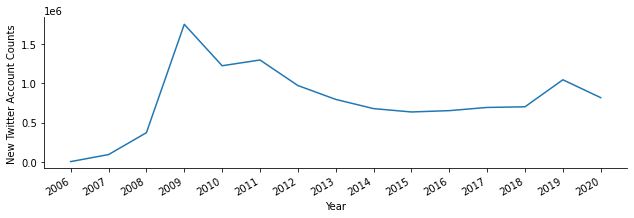

In [ ]:
account_created_at_date = twitter_explore['account_created_at_date'].value_counts().rename_axis('Year').reset_index(name = 'New Twitter Account Counts').sort_values(by='Year')
a = sns.relplot(x = 'Year', y = 'New Twitter Account Counts', kind="line", data = account_created_at_date, height=3, aspect=3)
sns.FacetGrid.set(a, xticks=account_created_at_date['Year'])
a.fig.autofmt_xdate()

The figure below illustrates the relationship between Date and new Tweet counts. It shows that the number of new Tweets related to Coronavirus increased rapidly from Mar 9th and peaked around 400,000 on Mar 13th. This corresponds to the period of time when the United States and several more countries became aware of the Coronavirus and started to discuss issues related to it as well as measures to combat it. After that, the number of new Tweets remained high for a while and has gradually decreased over time. Recently, the number of new Tweets remained stable at around 200,000, as governments started to take measures and people were getting calmer and used to the new situation.



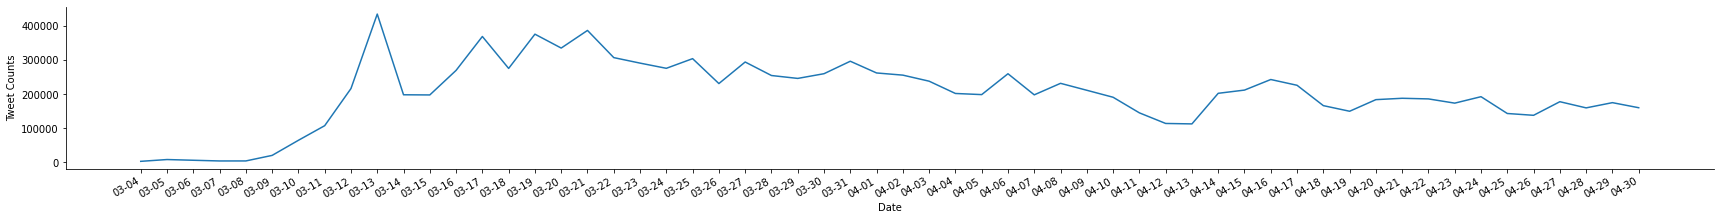

In [ ]:
tweet_created_at_date = twitter_explore['tweet_created_at_date'].value_counts().rename_axis('Date').reset_index(name = 'Tweet Counts').sort_values(by='Date')

b = sns.relplot(x = 'Date', y = 'Tweet Counts', kind="line", data = tweet_created_at_date, height=3, aspect=8)
sns.FacetGrid.set(b, xticks = tweet_created_at_date['Date'])
b.fig.autofmt_xdate()

This figure below illustrates the relationship between time and new Tweet counts. It simply shows an interesting pattern that the number of new Tweets first increases then decreases during a day. People tend to tweet more in the afternoon and less in the morning and evening.

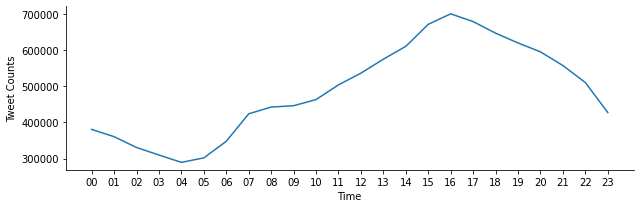

In [ ]:
tweet_created_at_time = twitter_explore['tweet_created_at_time'].value_counts().rename_axis('Time').reset_index(name = 'Tweet Counts').sort_values(by='Time')

c = sns.relplot(x = 'Time', y = 'Tweet Counts', kind="line", data = tweet_created_at_time, height=3, aspect=3)

### Textual Analysis

This part provides a basic understanding of the Tweet counts and lengths among different languages as well as  hashtags and @ in Tweets. 

The figure below shows the total number of Tweets and the average length of Tweets for the top 20 languages with the most Tweet counts. While the overwelming majority of Tweets are in English with around 6,000,000 counts and 140 words, the second highest number of Tweets are in Spanish with around 2,000,000 counts and 170 words. This is expected since English and Spanish are the two most common languages in the world expect for Chinese, but Twitter is banned in China.

While most languages have Tweets fewer than 1,000,000, their text lengths spread from 140 for English to 210 for Greek and Turkish. This is mainly due to the inherent differences in languages. It also suggests that if any textual features is used as part of the model, then the model should make predictions for only one language, considering the textual differences among languages. 

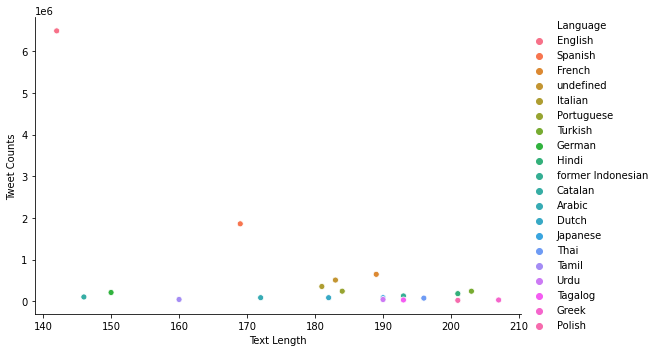

In [ ]:
language = twitter_explore['language'].value_counts().rename_axis('Language').reset_index(name = 'Tweet Counts')
text_length = twitter_explore.groupby('language', as_index = False).mean()[['language', 'text_length']]
language['text_length'] = text_length["text_length"].map(lambda x: int(x))
language.rename(columns = {'text_length':'Text Length'}, inplace = True) 
language = language.sort_values(by = 'Tweet Counts', ascending = False)[0:20]

d = sns.relplot(x = 'Text Length', y = 'Tweet Counts', hue="Language", data = language, height=5, aspect=1.5)

The figure below illustrates the distribution of number of hashtags and the number of @ among Tweets. It shows that while most Tweets have 0-1 "@", the number of "#" are distributed more evenly between 0 to 5. The majority of Tweets, however, have 2-3 hastags and @ 0-1 person.

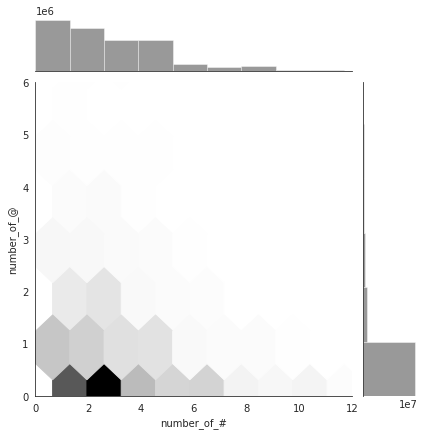

In [ ]:
hashtags_at = twitter_explore[['number_of_#', 'number_of_@']]

with sns.axes_style("white"):
    e = sns.jointplot(x = 'number_of_#' , y = 'number_of_@', data = hashtags_at, xlim = (0,12), ylim = (0,6), kind="hex", color="k")

The two word clouds below show the most commonly used words for the top and bottom 10% of Tweets in terms of the number of favorites and present some interesting observations. For the Tweets with the most number of favorites, they have a large number of "AMP", which is what Twitter uses to change the look of HTML links. This shows that sharing articles causes more favorites. While Tweets with the most favorites also more frequently talk about trump, realdonaldtrump, and thank, Tweets with the least favorites talk more about delivery, copy, and officials.

In [ ]:
most_favorite = twitter_explore.loc[twitter_explore['language']=='English'].sort_values(by = 'favourites_count', ascending = False).iloc[0:648926]
least_favorite = twitter_explore.loc[twitter_explore['language']=='English'].sort_values(by = 'favourites_count', ascending = True).iloc[0:648926]

most_favorite = most_favorite[most_favorite['text'].notna()]
most_favorite['text'] = most_favorite['text'].apply(lambda x: x.lower())

most_favorites = []
for text in most_favorite['text']:
  text = text.translate(str.maketrans('', '', string.punctuation))
  most_favorites.append(text)

most_favorites_tokens = []
tokenizer = RegexpTokenizer(r'\w+')
for word in most_favorites:
  words = tokenizer.tokenize(word)
  for word in words:
    most_favorites_tokens.append(word)

least_favorite = least_favorite[least_favorite['text'].notna()]
least_favorite['text'] = least_favorite['text'].apply(lambda x: x.lower())

least_favorites = []
for text in least_favorite['text']:
  text = text.translate(str.maketrans('', '', string.punctuation))
  least_favorites.append(text)

least_favorites_tokens = []
tokenizer = RegexpTokenizer(r'\w+')
for word in least_favorites:
  words = tokenizer.tokenize(word)
  for word in words:
    least_favorites_tokens.append(word)

In [ ]:
stop_words = set(stopwords.words('english')) 

filtered_most_favorites = []
for word in most_favorites_tokens:
  if word not in stop_words:
    filtered_most_favorites.append(word)

filtered_least_favorites = []
for word in least_favorites_tokens:
  if word not in stop_words:
    filtered_least_favorites.append(word)

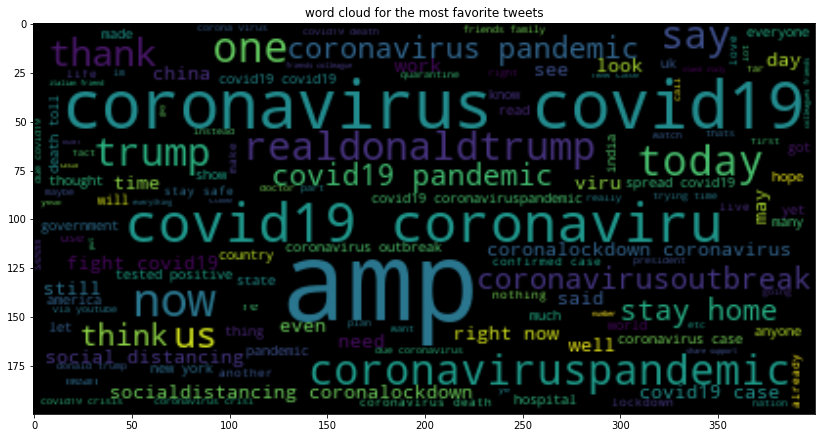

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
most_favorites = TreebankWordDetokenizer().detokenize(most_favorites_tokens)
wordcloud_highest = WordCloud().generate(most_favorites)

plt.figure(figsize=(14,20))
plt.imshow(wordcloud_highest, interpolation="bilinear")
plt.title('word cloud for the most favorite tweets')
plt.show()

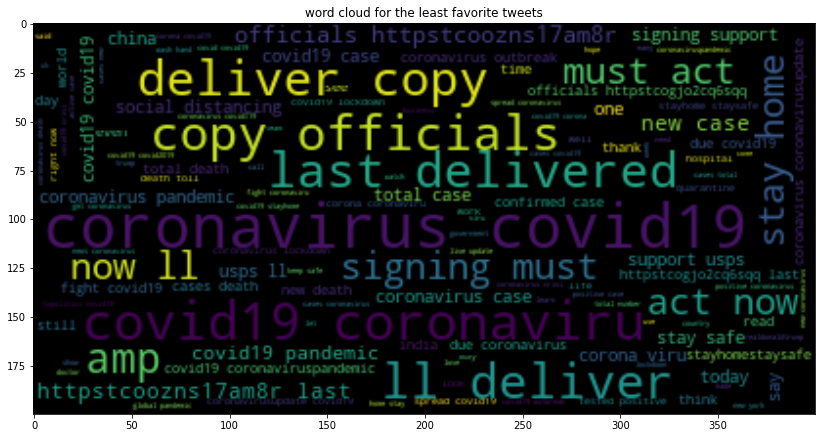

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
least_favorites = TreebankWordDetokenizer().detokenize(least_favorites_tokens)
wordcloud_highest = WordCloud().generate(least_favorites)

plt.figure(figsize=(14,20))
plt.imshow(wordcloud_highest, interpolation="bilinear")
plt.title('word cloud for the least favorite tweets')
plt.show()

### Popularity Analysis

This part provides a basic understanding of the popularity of Twitter accounts and Tweets and the correlations between their features. While the number of followers "followers_count" and the number of friends "friends_count" represent the popularity of Twitter accounts, the number of favorites "favourites_count" and the number of retweets "retweet count" represent the popularity of Tweets. 

The figures below show the distributions of "favourites_count", "retweet_count", "followers_count", and "friends_count". It shows that the distributions are extremely uneven for each of the features and all of them are very concentrated close to 0 and 1.

(array([1.1725674e+07, 6.0900000e+02, 2.4800000e+02, 3.0000000e+01,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]),
 array([      0. ,  442628.6,  885257.2, 1327885.8, 1770514.4, 2213143. ,
        2655771.6, 3098400.2, 3541028.8, 3983657.4, 4426286. ]),
 <a list of 10 Patch objects>)

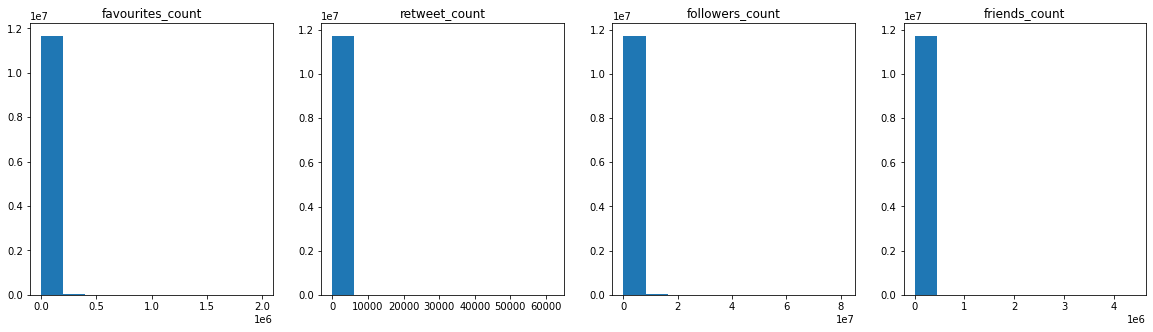

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 5)


ax1 = fig.add_subplot(1,4,1)
ax1.set_title('favourites_count')

ax2 = fig.add_subplot(1,4,2)
ax2.set_title('retweet_count')

ax3 = fig.add_subplot(1,4,3)
ax3.set_title('followers_count')

ax4 = fig.add_subplot(1,4,4)
ax4.set_title('friends_count')

ax1.hist(twitter_explore['favourites_count'])
ax2.hist(twitter_explore['retweet_count'])
ax3.hist(twitter_explore['followers_count'])
ax4.hist(twitter_explore['friends_count'])

Given the extremely uneven distribution and the high range of data, the following functions rescaled the features to log scale (base e) and plotted their distributions. The distributions of "favourites_log", "followers_log" and "friends_log became more like normal distribution curves.

In [ ]:
twitter_explore['favourites_log'] = np.log(twitter_explore["favourites_count"]+1)
twitter_explore['retweet_log'] = np.log(twitter_explore["retweet_count"]+1)
twitter_explore['followers_log'] = np.log(twitter_explore["followers_count"]+1)
twitter_explore['friends_log'] = np.log(twitter_explore["friends_count"]+1)

(array([3.292510e+05, 4.914710e+05, 1.486218e+06, 3.434052e+06,
        3.991216e+06, 1.678462e+06, 2.495190e+05, 6.182800e+04,
        4.275000e+03, 2.710000e+02]),
 array([ 0.        ,  1.53030716,  3.06061433,  4.59092149,  6.12122866,
         7.65153582,  9.18184298, 10.71215015, 12.24245731, 13.77276448,
        15.30307164]),
 <a list of 10 Patch objects>)

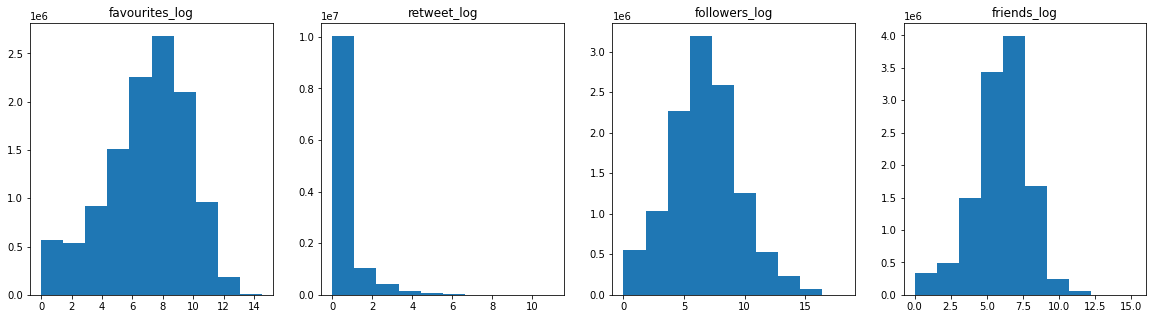

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 5)
ax1 = fig.add_subplot(1,4,1)
ax1.set_title('favourites_log')

ax2 = fig.add_subplot(1,4,2)
ax2.set_title('retweet_log')

ax3 = fig.add_subplot(1,4,3)
ax3.set_title('followers_log')

ax4 = fig.add_subplot(1,4,4)
ax4.set_title('friends_log')

ax1.hist(twitter_explore['favourites_log'])
ax2.hist(twitter_explore['retweet_log'])
ax3.hist(twitter_explore['followers_log'])
ax4.hist(twitter_explore['friends_log'])

To have a better understanding of the distribution of Tweets, the figure below illustrates the relationship between "retweet_log" and "favourites_log". It shows that the overwhelming majority of Tweets have favorites_log between 6-8 and a retweet_log of close to 0.  

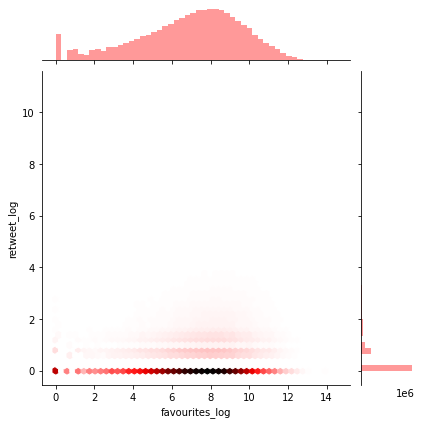

In [ ]:
favorites_retweets = twitter_explore[['favourites_log', 'retweet_log']]
f = sns.jointplot(x = 'favourites_log' , y = 'retweet_log', data = favorites_retweets, kind="hex", color = 'r')

To have a better understanding of the distribution of Twitter accounts, the figure below illustrates the relationship between "friends_log" and "followers_log". It shows that the overwhelming majority of Tweets have a followers_log between 5-10 and a retweet_log of 4-8. Furthermore, the figure shows that there seems to exist a positive correlation between the two features.

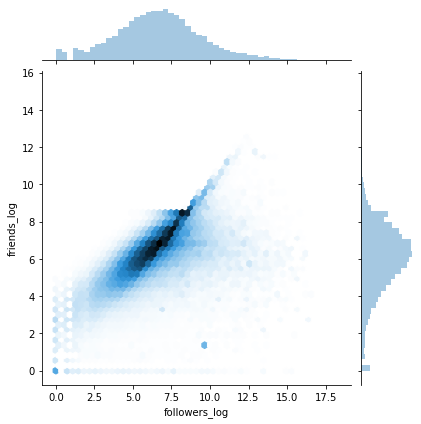

In [ ]:
favorites_accounts = twitter_explore[['followers_log', 'friends_log']]
g = sns.jointplot(x = 'followers_log' , y = 'friends_log', data = favorites_accounts, kind="hex")

The correlation matrix below provides a clearer illustration of the correlations among the four features. There is a relatively strong positive correlation (around 0.7) between "friends_log" and "favourites_log", and a moderate positive correlation between "followers_log" and "friends_log" as well as "followers_log" and "retweet_log". There are almost no correlations among the rest. 

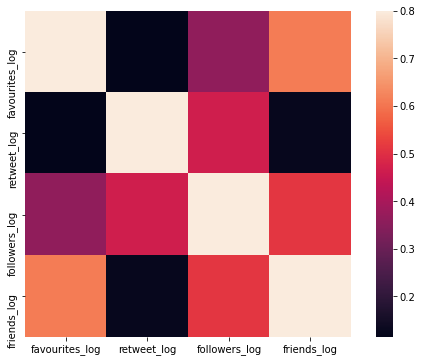

In [ ]:
correlations = twitter_explore[['favourites_log', 'retweet_log', 'followers_log', 'friends_log']]

corrmat = correlations.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, vmax=.8, square=True)

## Part 2 - Time Series & Country Analysis

#### Time Series Analysis

This part explores the change of Tweet counts over time and its interactions with Coronavirus cases and countries.

The figure below shows that while the number of Coronavirus cases has increased rapidly over time, the number of Tweets has slowly decreased. This implies that although Coronavirus is still on the rise globally, Twitter users are getting calmer and more used to it.

In [ ]:
twitter_country["created_at"] = pd.to_datetime(twitter_country["created_at"])
twitter_country["tweet_created_at_date"] = twitter_country["created_at"].dt.strftime('%yyyy-%m-%d').apply(lambda x: x[6:])

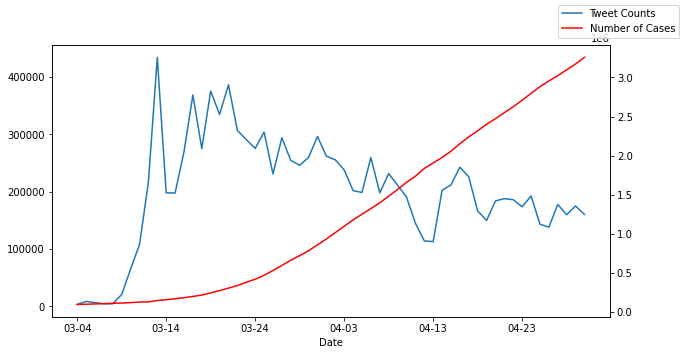

In [ ]:
tweet_time = twitter_explore['tweet_created_at_date'].value_counts().rename_axis('Date').reset_index(name = 'Tweet Counts')
coronavirus_time = coronavirus_time.merge(tweet_time, left_on = 'Date', right_on = 'Date')

ax = coronavirus_time.plot(x="Date", y="Tweet Counts", legend=False, figsize=(10,5))
ax2 = ax.twinx()
coronavirus_time.plot(x="Date", y="Number of Cases", ax=ax2, legend=False, color="r")
ax2.figure.legend()

This figure below illustrates the number of new Tweets every day across time by countries, which include the top 20 countries with the most cases of coronavirus. It shows that overall, the United States has the most number of Tweets, followed by India and the United Kingdom. Most countries have around 1000 new Tweets every day related to Coronavirus and the number slowly decreased overtime. 

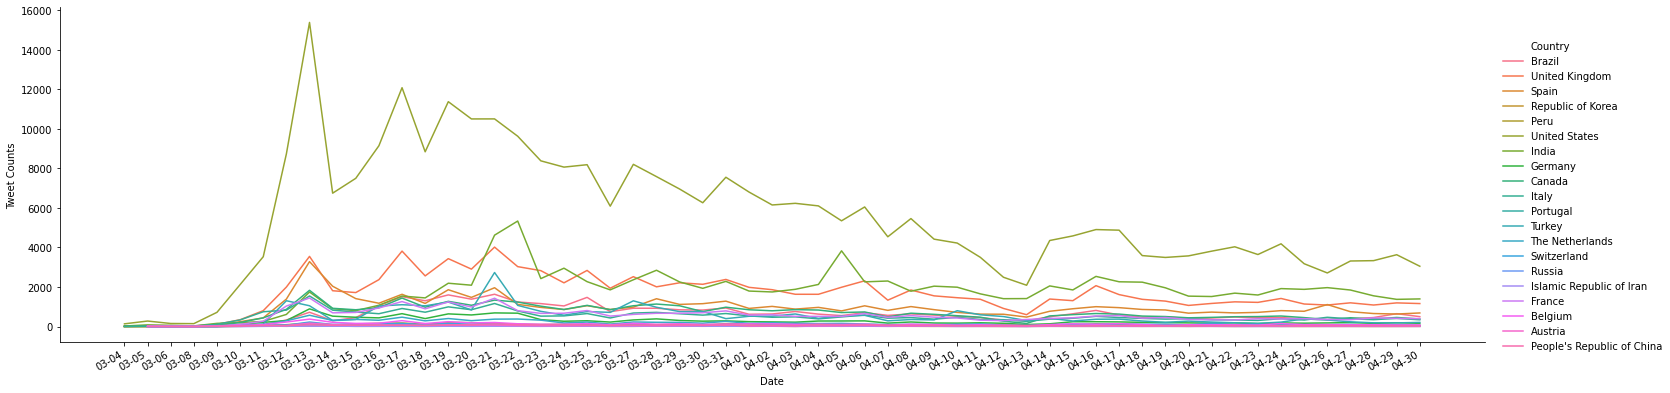

In [ ]:
most_coronavirus_country = coronavirus_country.sort_values(by='Number of Cases', ascending = False)[0:20]
tweet_time_country = twitter_country.loc[twitter_country['country'].isin(most_coronavirus_country['Country/Region'].unique())]
tweet_time_country = tweet_time_country.groupby(['tweet_created_at_date', 'country'], as_index = False).count()[['tweet_created_at_date', 'country', 'user_id']].sort_values(by='tweet_created_at_date')
tweet_time_country.columns = ['Date', 'Country', 'Tweet Counts']

m = sns.relplot(x = 'Date', y = 'Tweet Counts', kind="line", hue = 'Country', data = tweet_time_country, height=6, aspect=3.5)
m.fig.autofmt_xdate()

#### Country Analysis

This part explores the interaction of Tweets with the number of Coronavirus cases and countries.

The figure below illustrates the number of Tweets and the number of confirmed Coronavirus cases of the top 20 countries with the most Coronavirus cases in total. It shows that with a few exceptions, countries with more Coronavirus cases tend to have a higher number of Tweets. The United States by far has the most number of cases and the most number of Tweets, far exceeding all other countries. Other interesting cases include India, which has a low number of cases and a relatively high number of Tweets. This is probably not only because Twitter is very widely used in India, but also because the number of real cases far exceed the number of official cases given that India was not doing enough tests. China, on the other hand, has a relatively high number of cases but low number of Tweets, which is mainly because Twitter is banned in China and only people with VPN and government official accounts can tweet. 

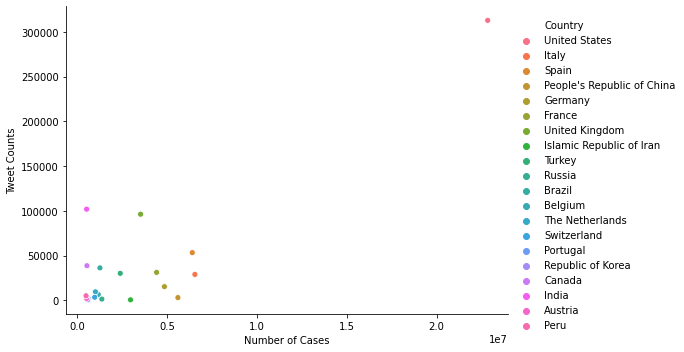

In [ ]:
tweet_country = twitter_country['country'].value_counts().rename_axis('Country').reset_index(name = 'Tweet Counts')
coronavirus_country = coronavirus_country.merge(tweet_country, left_on = 'Country/Region', right_on = 'Country')
coronavirus_country = coronavirus_country.sort_values(by = 'Number of Cases', ascending = False)[0:20]

k = sns.relplot(x="Number of Cases", y="Tweet Counts", hue="Country", data=coronavirus_country, height=5, aspect=1.5)

The figure below shows the average number of retweets and favorites for the top 20 countries with the highest average number of retweets. Surprisingly, the highest average number of retweets is only around 30 from Vatican City, followed by 11 from Thailand. This implys that while there are only several Tweets with very high retweets, the overwhelming majority of Tweets only have 0-1 retweet, which makes the average number of retweets very low. The average number of favourites, on the other hand, is much higher and expands across a much wider range. Among the top 20 countries, Israel has the highest average number of likes of around 30000, followed by South Sudan and Republic of Slovenia.

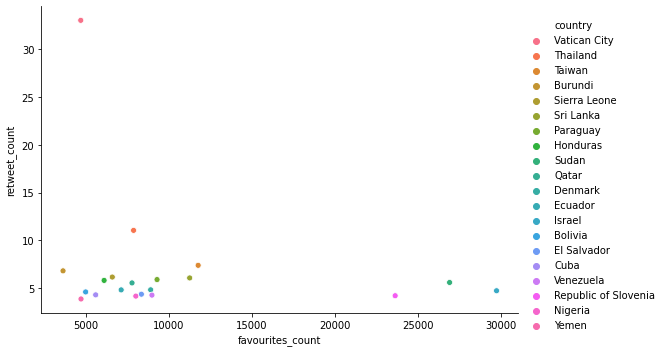

In [ ]:
country_favorites_retweets = twitter_country.groupby('country', as_index = False).mean()[['country','favourites_count', 'retweet_count']]
country_favorites_retweets = country_favorites_retweets.sort_values(by ='retweet_count', ascending = False)[0:20]

l = sns.relplot(x="favourites_count", y="retweet_count", hue="country", data=country_favorites_retweets, height=5, aspect=1.5)

## Part 3 - Modeling

### Data Cleaning & Feature Engineering

Part 3 - Modeling will build and optimize a linear regression model as well as a random forest regression model in spark to predict the number of retweets of Tweets only in English. `twitter_en` is used as the training data and some data processing will be similar to the EDA part. 

#### Time data



The function below changes the date data to the right format.

"tweet_created_at_date" is the date of Tweet and 'tweet_created_at_time' is the hour of Tweet.

In [ ]:
twitter_en["created_at"] = pd.to_datetime(twitter_en["created_at"])
twitter_en["tweet_created_at_date"] = twitter_en["created_at"].dt.strftime('%yyyy-%m-%d').apply(lambda x: x[6:])
twitter_en["tweet_created_at_time"] = twitter_en["created_at"].dt.strftime('%H:%M:%S').apply(lambda x: x[0:2])

#### Missing data

The function below drops 'country_code', 'place_full_name', and 'place_type' because more than 95% of them are null. 

The function below also fills the missing values in the "source" column with "missing".

In [ ]:
twitter_en.isna().sum()

user_id                         0
created_at                      0
text                            0
source                         72
favourites_count                0
retweet_count                   0
country_code             12343514
place_full_name          12340057
place_type               12340057
followers_count                 0
friends_count                   0
account_created_at              0
verified                        0
lang                            0
tweet_created_at_date           0
tweet_created_at_time           0
dtype: int64

In [ ]:
twitter_en = twitter_en.drop(['country_code', 'place_full_name', 'place_type'], axis=1)
twitter_en = twitter_en.fillna("missing") 

#### Textual Data

The functions below extract useful textual information from the texts of Tweets.

"number_of_#" has the number of hashtags in each Tweet.

"number_of_@" has the number of @ in each Tweet.

"text_length" has the length of text for each Tweet.

In [ ]:
twitter_en["number_of_#"] = twitter_en["text"].map(lambda x: x.count("#"))

In [ ]:
twitter_en["number_of_@"] = twitter_en["text"].map(lambda x: x.count("@"))

In [ ]:
twitter_en["text_length"] = twitter_en["text"].map(lambda x: len(x))

#### Numerical Data

The functions below rescale the "favourites_count", "retweet_count", "followers_count" and "friends_count" to log scale (base e) to avoid numerical instability issues because the range of data is really high. The log values are stored as "favourites_log", "retweet_log", "followers_log" and "friends_log". The plot shows that the distributions of log values are similar to the ones in EDA. While "favourites_count", "followers_count" and "friends_count" became more like normal distribution curves, the distribution of "retweet_log" is still very uneven.

In [ ]:
twitter_en['favourites_log'] = np.log(twitter_en["favourites_count"]+1)
twitter_en['retweet_log'] = np.log(twitter_en["retweet_count"]+1)
twitter_en['followers_log'] = np.log(twitter_en["followers_count"]+1)
twitter_en['friends_log'] = np.log(twitter_en["friends_count"]+1)

(array([3.637100e+05, 4.828480e+05, 1.515332e+06, 3.607667e+06,
        4.447479e+06, 2.132096e+06, 3.481910e+05, 7.436100e+04,
        6.431000e+03, 4.020000e+02]),
 array([ 0.        ,  1.53030716,  3.06061433,  4.59092149,  6.12122866,
         7.65153582,  9.18184298, 10.71215015, 12.24245731, 13.77276448,
        15.30307164]),
 <a list of 10 Patch objects>)

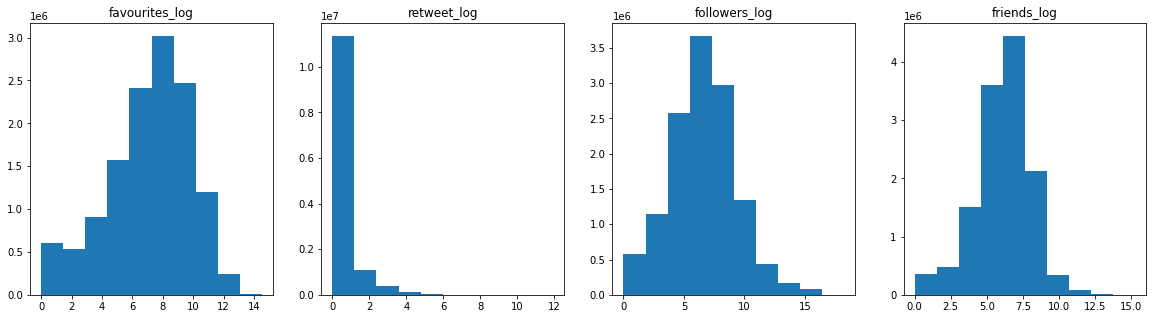

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 5)
ax1 = fig.add_subplot(1,4,1)
ax1.set_title('favourites_log')

ax2 = fig.add_subplot(1,4,2)
ax2.set_title('retweet_log')

ax3 = fig.add_subplot(1,4,3)
ax3.set_title('followers_log')

ax4 = fig.add_subplot(1,4,4)
ax4.set_title('friends_log')

ax1.hist(twitter_en['favourites_log'])
ax2.hist(twitter_en['retweet_log'])
ax3.hist(twitter_en['followers_log'])
ax4.hist(twitter_en['friends_log'])

#### Categorical Data

"tweet_created_at_date" and "tweet_created_at_time" are two categorical features, the functions below convert them into one hot vectors.

In [ ]:
twitter_en['tweet_created_at_date'] = twitter_en.tweet_created_at_date.astype('category')
twitter_en['tweet_created_at_time'] = twitter_en.tweet_created_at_time.astype('category')

In [ ]:
twitter_en = pd.get_dummies(twitter_en, columns=['tweet_created_at_date'])
twitter_en = pd.get_dummies(twitter_en, columns=['tweet_created_at_time'])

### Resampling

As shown above, while "retweet_log" is used as the label for the model, its distribution is very imbalanced. The functions below reduces the amount of retweet_log that is smaller than 1 to achieve a more balanced dataset, as shown in the figure. 

In [ ]:
small_retweet = twitter_en.loc[(twitter_en['retweet_log']>=0) & (twitter_en['retweet_log']<1)]
small_retweet = small_retweet.sample(frac = 0.05) 

In [ ]:
twitter_model = pd.concat([twitter_en.loc[twitter_en['retweet_log']>=1], small_retweet])

(array([1.197176e+06, 1.077856e+06, 3.809070e+05, 1.173140e+05,
        3.687000e+04, 1.010900e+04, 2.406000e+03, 5.150000e+02,
        7.100000e+01, 7.000000e+00]),
 array([ 0.        ,  1.19167092,  2.38334183,  3.57501275,  4.76668366,
         5.95835458,  7.1500255 ,  8.34169641,  9.53336733, 10.72503824,
        11.91670916]),
 <a list of 10 Patch objects>)

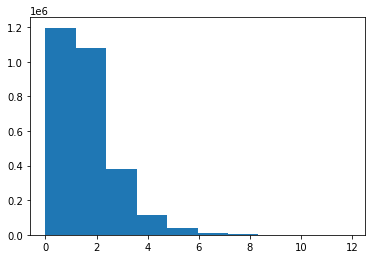

In [ ]:
plt.hist(twitter_model['retweet_log'])

The code below changes "retweet_log" to "label" and drops unnecessary columns to prepare for the training dataset.

In [ ]:
twitter_model.rename(columns = {'retweet_log':'label'}, inplace = True)
twitter_model = twitter_model.drop(['user_id', 'created_at', 'text', 'source', 'favourites_count', 'retweet_count', 'followers_count', 'friends_count', 'verified', 'lang', 'account_created_at'], axis=1)

Export `twitter_model` for use in Spark.

In [ ]:
twitter_model.to_csv('twitter_model.csv', quoting=csv.QUOTE_NONNUMERIC, index = False)

### Machine Learning with Spark

#### Spark Set Up

In [ ]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk is already the newest version (8u252-b09-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
  0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
* 2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2


In [ ]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
--2020-05-07 02:17:58--  https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving www-us.apache.org (www-us.apache.org)... 40.79.78.1
Connecting to www-us.apache.org (www-us.apache.org)|40.79.78.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz [following]
--2020-05-07 02:17:59--  https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 2a01:4f8:10a:201a::2
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232530699 (222M) [application/x-gzip]
Savin

In [ ]:
!apt update
!apt install gcc python-dev libkrb5-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [1,205 kB]
Fetched 1,457 kB 

In [ ]:
import os
memory = '20g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml-hw4').getOrCreate()

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
from pyspark.ml.regression import LinearRegression

In [ ]:
twitter_model = pd.read_csv('/content/gdrive/My Drive/PENN/2020 Spring/CIS 545 Big Data Analytics/Final Project/twitter_model.csv')

#### Data Preparation

Read in the prepared training data `twitter_model` into a spark dataframe and extract feature columns.

In [ ]:
twitter_sdf = spark.read.format("csv").option("header", "true").load("twitter_model.csv", inferSchema = True)

In [ ]:
feature_columns = twitter_sdf.drop('label').schema.names
feature_columns = feature_columns

Use VectorAssembler() to create a feature vector from all categorical and numerical features and call the final vector as “features”.

In [ ]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

The function below creates a pipeline with a single stage and fits the pipeline to the data. 

It creates the transformed dataframe and name it 'modified_data_sdf'.

In [ ]:
pipe = Pipeline(stages = [assembler])
model = pipe.fit(twitter_sdf)
modified_data_sdf = model.transform(twitter_sdf)

Create train and test sets by splitting the data into an 80-20 ratio between the train and test sets.

In [ ]:
train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8, 0.2], seed = 123)

#### Linear Regression


Since the label "retweet_log" is a continues output, I first tried using linear regression to perform the regression task. This part first trains a basic OLS linear regression model then trains models with different regularization parameters. The best train RMSE and test RMSE from linear regression are respectively 0.976 and 0.980 without any regularization. Regularization parameters, including L1, L2 and elastic net, failed to improve RMSE, which shows that the ordinary least square regression wasn't overfitting. 

In [ ]:
lr = LinearRegression(featuresCol = 'features', labelCol='label')
lr_model = lr.fit(train_sdf)
trainingSummary = lr_model.summary

print("Linear Regression - train RMSE: %f" % trainingSummary.rootMeanSquaredError)

Linear Regression - train RMSE: 0.975792


In [ ]:
predictions = lr_model.transform(test_sdf)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
test_rmse_orig = evaluator.evaluate(predictions)
print("Linear Regression - test RMSE: %f" % test_rmse_orig)

Linear Regression - test RMSE: 0.979992


##### Regularization Parameters - L1, L2 and Elastic Net 

In [ ]:
l1 = LinearRegression(featuresCol = 'features', labelCol='label', regParam=0.1, elasticNetParam=1)
l1_model = l1.fit(train_sdf)

l2 = LinearRegression(featuresCol = 'features', labelCol='label', regParam=0.1, elasticNetParam=0)
l2_model = l2.fit(train_sdf)

elastic_net = LinearRegression(featuresCol = 'features', labelCol='label', regParam=0.1, elasticNetParam=0.8)
elastic_net_model = elastic_net.fit(train_sdf)

print("Linear Regression L1 - train RMSE: %f" % l1_model.summary.rootMeanSquaredError)
print("Linear Regression L2 - train RMSE: %f" % l2_model.summary.rootMeanSquaredError)
print("Linear Regression Elastic Net - train RMSE: %f" % elastic_net_model.summary.rootMeanSquaredError)

Linear Regression L1 - train RMSE: 0.995307
Linear Regression L2 - train RMSE: 0.977487
Linear Regression Elastic Net - train RMSE: 0.992419


In [ ]:
l1_predictions = l1_model.transform(test_sdf)

evaluator_L1 = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
test_rmse_l1 = evaluator_L1.evaluate(l1_predictions)
print("Linear Regression L1 - test RMSE: %f" % test_rmse_l1)

Linear Regression L1 - test RMSE: 0.999201


In [ ]:
l2_predictions = l2_model.transform(test_sdf)

evaluator_L2 = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
test_rmse_l2 = evaluator_L2.evaluate(l2_predictions)
print("Linear Regression L2 - test RMSE: %f" % test_rmse_l2)

Linear Regression L2 - test RMSE: 0.981598


In [ ]:
elastic_net_predictions = elastic_net_model.transform(test_sdf)

evaluator_elastic = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
test_rmse_elastic = evaluator_elastic.evaluate(elastic_net_predictions)
print("Linear Regression Elastic Net - test RMSE: %f" % test_rmse_elastic)

Linear Regression Elastic Net - test RMSE: 0.996325


#### Random Forest Regression

Next, I tried using random forest regression to see if it could improve model performance since its bagging ensembles should make it more accurate. This part trains and optimizes a random forest regression model while tuning hyperparameters. The train RMSE and test RMSE of the model decreased from around 0.99 respectively to 0.820 and 0.906 as maxDepth and numTrees increased respectively from 2 to 20 and 5 to 25. The best performace of the random forest regression model had a train RMSE of 0.820 and a test RMSE of 0.906 with maxDepth=20 and numTrees=25. This shows that random forest regression can perform better than linear regression after hyperparameter optimization.

In [ ]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'label', maxDepth=20, numTrees=25)
rfModel = rf.fit(train_sdf)

training_predictions = rfModel.transform(train_sdf)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
train_rmse_rf = evaluator.evaluate(training_predictions)

print("Random forest - train RMSE: %f" % train_rmse_rf)

Random forest - train RMSE: 0.819697


In [ ]:
predictions = rfModel.transform(test_sdf)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
test_rmse_rf = evaluator.evaluate(predictions)

print("Random forest - test RMSE: %f" % test_rmse_rf)

Random forest - test RMSE: 0.905561


##### Dimensionality Reduction with PCA

The function below conducts principal component analysis to reduce the number of dimensions of the dataset with sklearn and plots the explained_variance_ratio against the number of components. The figure shows that the number of components to keep is 80 as it explains more than 95% of variance in the dataset. 

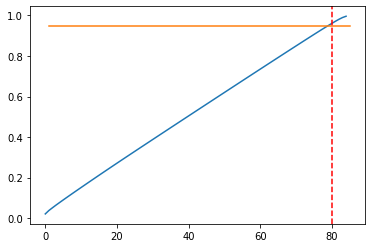

In [ ]:
label = twitter_model['label']
features = twitter_model.drop(['label'], axis=1)

features = StandardScaler().fit_transform(features)

pca = PCA(n_components=85)
X2 = pca.fit_transform(features)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(pc_vs_variance)
x_coordinates = [1, 85]
y_coordinates = [0.95, 0.95]
plt.plot(x_coordinates, y_coordinates)
plt.axvline(x=81, color = 'r', linestyle='dashed')

Fit and transform pca on training set using 80 as the number of components. Due to the memory contraint in Spark, hyperparameters maxDepth and numTrees couldn't be set to the same level as above. The best hyperparameters are maxDepth=8, numTrees=10, which returned a train RMSE of 0.965 and a test RMSE of 0.958. This shows that PCA did not greatly improve the model performance. 

In [ ]:
pca = PCA(k=80, inputCol="features", outputCol="pca")
pca_model = pca.fit(train_sdf)
pca_train = pca_model.transform(train_sdf)

rf_pca = RandomForestRegressor(featuresCol = 'pca', labelCol = 'label', maxDepth=8, numTrees=10)
rfModel_pca = rf_pca.fit(pca_train)

In [ ]:
training_predictions = rfModel_pca.transform(pca_train)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
train_rmse_rf_pca = evaluator.evaluate(training_predictions)
train_rmse_rf_pca

print("Random forest with PCA - train RMSE: %f" % train_rmse_rf_pca)

Random forest with PCA - train RMSE: 0.965461


In [ ]:
pca_test = pca_model.transform(test_sdf)
predictions = rfModel_pca.transform(pca_test)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
test_rmse_rf_pca = evaluator.evaluate(predictions)

print("Random forest with PCA - test RMSE: %f" % test_rmse_rf_pca)

Random forest with PCA - test RMSE: 0.958467


## Challenges

There are mainly three challenges in this project. 

First, it was more difficult to read and process big data. The original datasets for Tweets in March and April had more than 23 million data entries in total and it was impossible to read them into colab without running out of RAM, so I had to do some basically cleaning for each dataset before I read them and concat them. After reading all the data, the data processing and cleaning process also took relatively longer time and a lot of RAM. To make it more efficient, I seperated the original data into three different datasets for different parts of analysis.

Second, it was challenging to handle the large amount of training data (around 3 million) for machine learning. I used Spark instead of sklearn because sklearn couldn't process that amount of training data. I also increased Spark memory space by resetting spark executor memory and spark driver memory. However, I still encountered an error of computation space when I adjusted the parameters of random forest regression (maxDepth and numTrees) to a higher number as well as when I fit and transformed pca on the training data.

Last but not least, there were some challenges when preparing the training data for modeling. The distribution of the training data was very wide and extremely uneven. While the number of retweets ranged from 0 to 60,000, more than 95% of the Tweets had retweet counts of 0 or 1. This made it very difficult to resample the dataset to achieve a balanced distribution. Furthermore, certain data points in the training data present inconsistent values. For example, a Tweet can have 25237 favorites with only 1 retweet and 300 followers, or thousands of retweets with no favorites. I think the reason might be that the bots on Twitter make it possible for users to manipulate their amount of favorites, retweets, or followers. These types of inconsistent data points may interfere with the modeling and decrease model performance. 

## Next Steps

There are mainly four steps to take to address the challenges. First, collect more training data to achieve a better distribution of the dataset with resampling. Second, use AWS to increase the capacity for model optimizing with a higher range of hyperparameter tuning. Third, find ways to identify and remove problematic Tweets that use bots to increase their favorites or retweets to avoid their interference to the model. Last but not least, try deep learning feedforward neural network to see if it could improve the performance of the model.